# WindFarmNetwork and Router

This notebook demonstrates how to use the key methods of the `WindFarmNetwork` class from the *OptiWindNet* package.

## ✅ WindFarmNetwork

The `WindFarmNetwork` class is the *central user-facing object* in the OptiWindNet API. It models and optimizes the electrical *collection network* of a wind farm, including turbines, substations, cabling, and routing.

###  Key Responsibilities

| Feature                      | Description                                                                                                                                    |
| ---------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Initialization & Parsing** | Accepts turbine/substation coordinates or layout graph `L`, validates cable data, and constructs the internal graph structure.                 |
| **Optimization**             | Interfaces with different routing strategies (`EWRouter`, `HGSRouter`, `MILPRouter`) to optimize the network layout for cost and cable length. |
| **Visualization**            | Provides plotting tools for location, links, mesh, and final network using matplotlib and custom plotting functions.                           |
| **Gradient & Update Tools**  | Computes gradients for optimization and allows updating network layouts using a compact "terse link" format.                                   |
| **Import/Export**            | Can be constructed from YAML, PBF, or WindIO formats for integration with real-world datasets.                                                 |

### Internally Uses:

* `self.L`: Location graph
* `self.A`: Available links (edges) from planar embedding
* `self.S`: Selected links (solution graph)
* `self.G`: Final cable network (after detour generation and cable assignment)

### Example Workflow

```python
# Initialize with coordinates and cable types
wf = WindFarmNetwork(cables=[(100, 10)], turbinesC=..., substationsC=...)

# Optimize layout using default router (Esau-Williams)
terse_links = wf.optimize()

# Access total cost or cable length
total_cost = wf.cost()
total_length = wf.length()

# Visualize network
wf.plot()
```

## 🧭 **Router**

In OptiWindNet, a `Router` is a strategy used to compute the optimal layout of the wind farm’s electrical collection network. Given turbine and substation locations, available cable options, and routing constraints, a router determines *which turbines connect to which substations* and how cables should be laid to *minimize length (and concequently cost)*.


### 🔌 **Currently Available Routers**

Currently, *OptiWindNet* includes *three router types*, each offering different trade-offs between speed and accuracy:

#### 🔹 **EWRouter** (modified Esau-Williams Heuristic)

* Fast and lightweight heuristic.
* Ideal for quick layout generation.
* Supports two feeder routing types: `"segmented"` and `"straight"`.

#### 🔹 **HGSRouter** (Hybrid Genetic Search)

* Metaheuristic approach based on CVRP.
* Balances quality and speed.
* Capable of limiting number of feeders

#### 🔹 **MILPRouter** (Mixed Integer Linear Programming)

* Exact optimization using MILP solvers like OR-Tools or Gurobi.
* Most accurate but computationally intensive.
* Supports warm-starting and advanced solver options.
* Supported model options:
    * cabling topology (branched or radial)
    * feeder route (segmented or straight)
    * limit on the number of feeders

Routers can be passed to the `WindFarmNetwork` object to control how the network is optimized during `.optimize()` calls.

> **Note:** Many of the Jupyter notebooks provided include SVG figures as output. To ensure these visuals are displayed correctly in JupyterLab or Jupyter Notebook, make sure the notebook is marked as **trusted**.
> *In JupyterLab, you can do this by pressing* `Ctrl + Shift + C` *and selecting* **Trust Notebook**.

Import required modules

In [12]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, EWRouter, MILPRouter, ModelOptions

In [13]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

## WindFarmNetwork

As explained at the begining of this notebook,  `WindFarmNetwork` is a high-level API abstraction that takes care of layout modeling, routing, optimization, and visualization for offshore wind farm electrical networks. It's designed to be both flexible and extensible, supporting multiple input formats and routing algorithms. In this section we will:
- Create a simple wind farm network
- Use heuristic and MILP optimization
- Explore key methods such as:
  - `.optimize()`
  - `.plot()`
  - `.cost()`, `.length()`
  - `.terse_links()`, `.update_from_terse_links()`
  - `.gradient()`
  - `.get_network()`

We start with dummy coordinates for 5 turbines and 1 substation, and define a simple cable type.


In [14]:
turbinesC = np.array([[0, 0], [1, 1], [2, 0], [3, 1], [4, 0]])
substationsC = np.array([[2, -2]])
cables = [(5, 100)]

wfn = WindFarmNetwork(
    cables=cables,
    turbinesC=turbinesC,
    substationsC=substationsC
)


### Method: `optimize(router=...)`

This is the main method that computes the electrical network based on a given routing algorithm (heuristic, metaheuristic or MILP).
 > Note that the router could be passed directly to `WindFarmNetwork(router=...)`.

#### Use a heuristic router (Esau-Williams)

<Axes: >

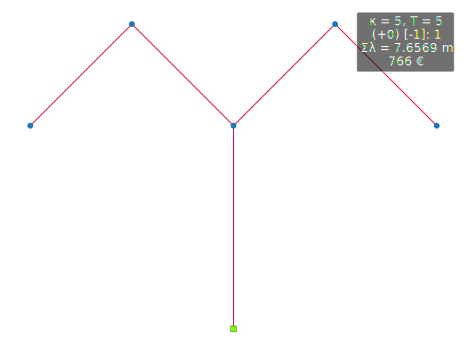

In [15]:
wfn.optimize(router=EWRouter())
wfn.plot()

#### Use a MILP router with full control over topology and feeders

The solution from the previous call to `wfn.optimize()` is stored within the `wfn` object.
If this solution is *feasible under the current `MILPRouter` settings*, it will be *automatically used as a warm start*.
Otherwise, if it does not meet the current `ModelOptions` constraints, it will be *ignored*, and the MILP solver will start from scratch.



    - branched structure not allowed under "radial" topology



<Axes: >

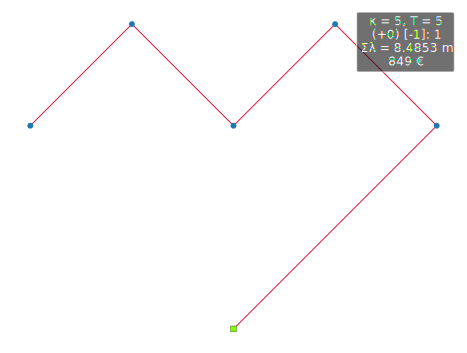

In [16]:
model_opts = ModelOptions(topology='radial', feeder_limit='minimum', feeder_route='straight')
wfn.optimize(router=MILPRouter(solver_name='ortools', time_limit=2, mip_gap=0.01, model_options=model_opts), verbose=True)
wfn.plot()

### Method: `plot()` and Variants

These methods help you visualize the layout at different stages:

- `plot_location()` – turbine/substation coordinates and border
- `plot()` – final optimized layout

> For a detailed explanation of this method see [Plotting Notebook](a04_Plotting.ipynb).


<Axes: >

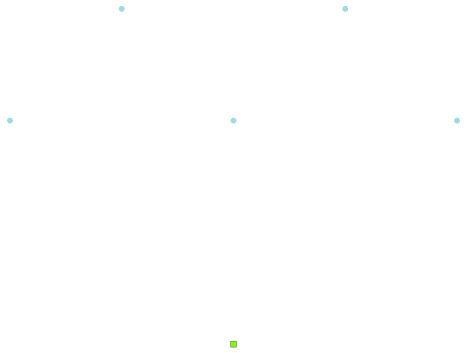

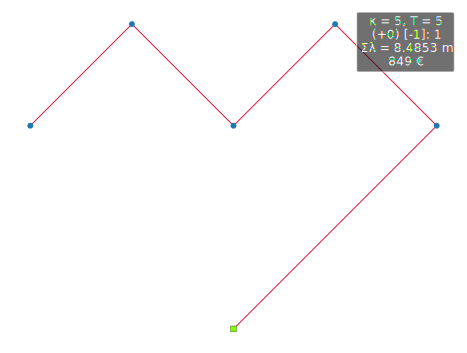

In [17]:
wfn.plot_location()
wfn.plot()

### Method: `cost()` and `length()`

Returns the total cost and cable length of the optimized network.

In [18]:
print("Network cost:", wfn.cost())
print("Network length:", wfn.length())

Network cost: 848.5281374238571
Network length: 8.485281374238571


### Method: `terse_links()` and `update_from_terse_links()`

A terse link is a compact way to describe how each turbine is connected in the electrical network. It’s just a list (or array) where:

* Each position `i` represents turbine `i`

* The value at position `i` is the node that turbine `i` connects to
(this could be another turbine or a substation)

Hence:

- `terse_links()` gives a compact array of link targets (integer representation).
- `update_from_terse_links()` allows you to reconstruct the network from this array, optionally updating coordinates.

In [19]:
terse = wfn.terse_links()
print("Terse link array:", terse)

Terse link array: [ 1  2  3  4 -1]


### Method: `update_from_terse_links()`

This method assumes a **valid and feasible network**, so it’s your responsibility to ensure that:
- The connections form a proper **feeder tree**
- Every turbine is (indirectly or directly) connected to a **substation**
- Capacity constraints are not violated

Suppose you have a wind farm with:
- **5 turbines** → nodes `0, 1, 2, 3, 4`
- **1 substation** → node `-1` (*Note: In optiwindnet, substations are assigned negative indices*)

We want the following connections:
- Turbine 0 → Substation (-1)
- Turbine 1 → Turbine 0
- Turbine 2 → Substation (-1)
- Turbine 3 → Turbine 2
- Turbine 4 → Turbine 3

This gives us the `terse_links` array:

```python
terse_links = [-1, 0, -1, 2, 3]

1
[]


<Axes: >

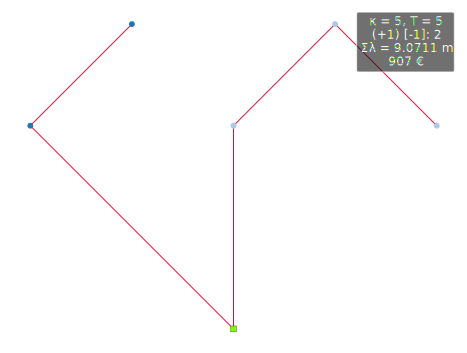

In [20]:
new_terse_links = np.array([-1, 0, -1, 2, 3])

# Apply the new configuration
wfn.update_from_terse_links(new_terse_links)

# Visualize the updated layout
wfn.plot()


### Method: `gradient()`

This method computes the gradient of the cost or length with respect to turbine/substation positions.
Useful for hybrid optimization or sensitivity analysis.
 > Note: default of `gradient_type` is `length`.

In [21]:
print('gradient_type=length\n')
grad_turb, grad_subs = wfn.gradient()
print("Gradient (w.r.t. turbines):\n", grad_turb)
print("Gradient (w.r.t. substations):\n", grad_subs)

print('\n ------------- \n')
print('gradient_type=length\n')
grad_turb, grad_subs = wfn.gradient(gradient_type='cost')
print("Gradient (w.r.t. turbines):\n", grad_turb)
print("Gradient (w.r.t. substations):\n", grad_subs)

gradient_type=length

Gradient (w.r.t. turbines):
 [[-1.41421356  0.        ]
 [ 0.70710678  0.70710678]
 [-0.70710678  0.29289322]
 [ 0.          1.41421356]
 [ 0.70710678 -0.70710678]]
Gradient (w.r.t. substations):
 [[ 0.70710678 -1.70710678]]

 ------------- 

gradient_type=length

Gradient (w.r.t. turbines):
 [[-141.42135624    0.        ]
 [  70.71067812   70.71067812]
 [ -70.71067812   29.28932188]
 [   0.          141.42135624]
 [  70.71067812  -70.71067812]]
Gradient (w.r.t. substations):
 [[  70.71067812 -170.71067812]]


### Method: `get_network()`

This method returns the **final optimized network** as a **structured NumPy array**, where each row represents an edge in the network.

Each edge includes detailed attributes such as:

* **`src`**: index of the source node
* **`tgt`**: index of the target (destination node)
* **`length`**: physical cable length
* **`load`**: electrical load carried through the cable (number of turbines)
* **`cable`**: index of the cable type used (e.g., 0 for first type in cable list)
* **`cost`**: cost associated with that cable

In [22]:
network_data = wfn.get_network()
network_data[:2]  # Preview first few edges

array([(0,  1, 1.41421356, 1., False, 0, 141.42135624),
       (0, -1, 2.82842712, 2., False, 0, 282.84271247)],
      dtype=[('src', '<i8'), ('tgt', '<i8'), ('length', '<f8'), ('load', '<f8'), ('reverse', '?'), ('cable', '<i8'), ('cost', '<f8')])

## ✅ Router

For examples about how to use different `Routers` in *OptiWindNet* see [QuickStart](quickstart_high.ipynb).

## ✅ Summary

In this notebook:

**I.** we explored the most useful methods of the `WindFarmNetwork` class:

| Method | Purpose |
|--------|---------|
| `optimize()` | Run optimization with a router |
| `plot()` | Visualize the network |
| `cost()`, `length()` | Get total cost and length |
| `terse_links()` | Get compact link encoding |
| `update_from_terse_links()` | Apply terse links manually |
| `gradient()` | Compute layout gradient |
| `get_network()` | Export the final network data |

**II.** Discussed `Routers` in *OptiWindNet*.

For deeper insights into individual methods, refer to the dedicated notebooks provided.
